Package needed

In [1]:
import pandas as pd
import numpy as np
from pulp import *
from dash import Dash, dcc, html, Input, Output
import plotly.express as px

c:\Users\ye2208\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\ye2208\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


1.0 Initial Data Input

In [2]:

# Table 1：Total Supply
supply_cum = {
    'Jan Wk2':230, 
    'Jan Wk3':270, 
    'Jan Wk4':320, 
    'Jan Wk5':380
}

# Table 2:Jan Wk1 Actual build
built = {
    'Superman':70, 
    'Superman_Plus':70, 
    'Superman_Mini':60
}

# Table 3: Demand Forecast
demand_cum = {
    'Superman':   [85, 100, 110, 120],    # Jan Wk2-Wk5
    'Superman_Plus': [85, 120, 150, 175],
    'Superman_Mini': [40, 60, 70, 75]
}

# Table 4：Superman Plus by channel needs （Jan Wk2-Wk5）
Superman_Plus_demand = {
    ('Online Store'):       [20, 30, 40, 50],
    ('Retail Store'):    [15, 25, 30, 35],
    ('Reseller', 'PAC'):     [25, 30, 35, 40],  # Prioritize PAC
    ('Reseller', 'AMR'):     [20, 25, 30, 35],
    ('Reseller', 'Europe'):  [5, 10, 15, 15]
}


# Cum Demand
def cum_to_weekly(cum_list):
    return [cum_list[0]] + [cum_list[i]-cum_list[i-1] for i in range(1,len(cum_list))]

Superman_Plus_demand_weekly = {k: cum_to_weekly(v) for k,v in Superman_Plus_demand.items()}

demand_weekly = {k: cum_to_weekly(v) for k,v in demand_cum.items()}


# Weekly Suppluy
supply_weekly = {
    'Jan Wk2': supply_cum['Jan Wk2'] - sum(built.values()),
    'Jan Wk3': supply_cum['Jan Wk3'] - supply_cum['Jan Wk2'],
    'Jan Wk4': supply_cum['Jan Wk4'] - supply_cum['Jan Wk3'],
    'Jan Wk5': supply_cum['Jan Wk5'] - supply_cum['Jan Wk4']
}

In [3]:
supply_cum

{'Jan Wk2': 230, 'Jan Wk3': 270, 'Jan Wk4': 320, 'Jan Wk5': 380}

In [4]:
supply_weekly 

{'Jan Wk2': 30, 'Jan Wk3': 40, 'Jan Wk4': 50, 'Jan Wk5': 60}

In [5]:
demand_cum

{'Superman': [85, 100, 110, 120],
 'Superman_Plus': [85, 120, 150, 175],
 'Superman_Mini': [40, 60, 70, 75]}

In [6]:
demand_weekly

{'Superman': [85, 15, 10, 10],
 'Superman_Plus': [85, 35, 30, 25],
 'Superman_Mini': [40, 20, 10, 5]}

In [7]:
Superman_Plus_demand           #Superman_Plus : By channel/customer

{'Online Store': [20, 30, 40, 50],
 'Retail Store': [15, 25, 30, 35],
 ('Reseller', 'PAC'): [25, 30, 35, 40],
 ('Reseller', 'AMR'): [20, 25, 30, 35],
 ('Reseller', 'Europe'): [5, 10, 15, 15]}

In [8]:
Superman_Plus_demand_weekly    #Superman_Plus : By channel/customer

{'Online Store': [20, 10, 10, 10],
 'Retail Store': [15, 10, 5, 5],
 ('Reseller', 'PAC'): [25, 5, 5, 5],
 ('Reseller', 'AMR'): [20, 5, 5, 5],
 ('Reseller', 'Europe'): [5, 5, 5, 0]}

1.1  Business Rule: Priotity

In [9]:
# ## Allocation Priority

# 1) First：Fulfill Superman, Superman_Mini
alloc_priority = {'Superman': [], 'Superman_Mini': []}
remaining_capacity = {}

for week_idx in range(4):
    wk = f'Jan Wk{week_idx+2}'
    
    # Superman Demand Gap
    superman_needed = max(0, demand_cum['Superman'][week_idx] - built['Superman'])
    superman_alloc= min(superman_needed, supply_weekly[wk])
    alloc_priority['Superman'].append(superman_alloc)
    built['Superman'] += superman_alloc
    
    # Mini Demand Gap
    mini_needed = max(0, demand_cum['Superman_Mini'][week_idx] - built['Superman_Mini'])
    mini_alloc = min(mini_needed, supply_weekly[wk] - superman_alloc)
    alloc_priority['Superman_Mini'].append(mini_alloc)
    built['Superman_Mini'] += mini_alloc
    
    # Remaining_Capacity
    remaining_capacity[wk] = supply_weekly[wk] - superman_alloc - mini_alloc

print("Remaining_Capacity:")
pd.DataFrame([remaining_capacity])


Remaining_Capacity:


,Jan Wk2,Jan Wk3,Jan Wk4,Jan Wk5
0,15,25,30,45


In [10]:
alloc_priority

{'Superman': [15, 15, 10, 10], 'Superman_Mini': [0, 0, 10, 5]}

1.2 Optimization Allocate

In [11]:
# 2) Opitimization Model:  LpProble, using pulp to solve the allocation problem

model = LpProblem("Superman_Plus_Allocation", LpMaximize)

weeks = ['Jan Wk2', 'Jan Wk3', 'Jan Wk4', 'Jan Wk5']
#channels = list(plus_demand_weekly.keys())
channels = list(Superman_Plus_demand_weekly.keys())
alloc_vars = LpVariable.dicts("Alloc", (channels, weeks), lowBound=0, cat='Integer')

# Objective Function：Maxmize Demand Needs（ Optimize latest week needs）
time_decay = [1.2**i for i in range(4)]  #  time_decay
model += lpSum([alloc_vars[c][w] * time_decay[weeks.index(w)] 
               for c in channels for w in weeks])

# Contraints:
for w in weeks:
    # Remaining_capacity constraint
    model += lpSum(alloc_vars[c][w] for c in channels) <= remaining_capacity[w]
    
    # Optimize Jan Wk4 PAC 
    if w == 'Jan Wk4':
        pac_reseller = [c for c in channels if c[1]=='PAC'][0]
        model += alloc_vars[pac_reseller][w] >= Superman_Plus_demand_weekly[pac_reseller][weeks.index(w)]

# Upper constraints
for c in channels:
    for week_idx, w in enumerate(weeks):
        model += alloc_vars[c][w] <= Superman_Plus_demand_weekly[c][week_idx]

# Solver
model.solve()


# ## Result Analysis

alloc_results = []
for c in channels:
    for w in weeks:
        val = value(alloc_vars[c][w])
        if val > 0:
            alloc_results.append({
                'Channel': c[0],
                'Region': c[1],
                'Week': w,
                'Allocated': val,
                'Demand': Superman_Plus_demand_weekly[c][weeks.index(w)],
                'Fulfill rate': f"{val/Superman_Plus_demand_weekly[c][weeks.index(w)]*100:.1f}%"
            })

# Visualize allocation results
allo_df = pd.DataFrame(alloc_results)

pivot_table = allo_df.pivot_table(
    index=['Channel','Region'], 
    columns='Week', 
    values=['Allocated','Demand'],
    aggfunc='sum'
)
print("Allocation：")
display(pivot_table)

# Validate  Optimize Jan Wk4 PAC 
print("\nOptimize Jan Wk4 PAC （Jan Wk4 PAC）：")
display([(allo_df['Region']=='PAC') & (allo_df['Week']=='Jan Wk4')])



Allocation：


Allocated                          Demand                  \
Week              Jan Wk2 Jan Wk3 Jan Wk4 Jan Wk5 Jan Wk2 Jan Wk3 Jan Wk4   
Channel  Region                                                             
O        n            NaN    10.0    10.0    10.0     NaN    10.0    10.0   
R        e           15.0     NaN     5.0     5.0    15.0     NaN     5.0   
Reseller AMR          NaN     5.0     5.0     5.0     NaN     5.0     5.0   
         Europe       NaN     5.0     5.0     NaN     NaN     5.0     5.0   
         PAC          NaN     5.0     5.0     5.0     NaN     5.0     5.0   

                         
Week            Jan Wk5  
Channel  Region          
O        n         10.0  
R        e          5.0  
Reseller AMR        5.0  
         Europe     NaN  
         PAC        5.0


Optimize Jan Wk4 PAC （Jan Wk4 PAC）：


[0     False
 1     False
 2     False
 3     False
 4     False
 5     False
 6     False
 7      True
 8     False
 9     False
 10    False
 11    False
 12    False
 13    False
 dtype: bool]

In [12]:
allo_df[(allo_df['Region']=='PAC') & (allo_df['Week']=='Jan Wk4')]

,Channel,Region,Week,Allocated,Demand,Fulfill rate
7,Reseller,PAC,Jan Wk4,5.0,5,100.0%


In [13]:
allo_df

,Channel,Region,Week,Allocated,Demand,Fulfill rate
0,O,n,Jan Wk3,10.0,10,100.0%
1,O,n,Jan Wk4,10.0,10,100.0%
2,O,n,Jan Wk5,10.0,10,100.0%
3,R,e,Jan Wk2,15.0,15,100.0%
4,R,e,Jan Wk4,5.0,5,100.0%
5,R,e,Jan Wk5,5.0,5,100.0%
6,Reseller,PAC,Jan Wk3,5.0,5,100.0%
7,Reseller,PAC,Jan Wk4,5.0,5,100.0%
8,Reseller,PAC,Jan Wk5,5.0,5,100.0%
9,Reseller,AMR,Jan Wk3,5.0,5,100.0%


In [14]:
allo_df.to_excel('Allocation_output/allo_df.xlsx')

C:\Users\ye2208\AppData\Local\Temp/ipykernel_24640/6350742.py:1: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.1' currently installed).
  allo_df.to_excel('Allocation_output/allo_df.xlsx')


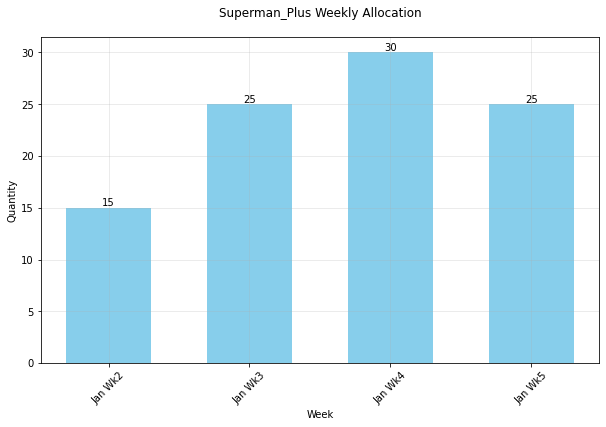

Week
Jan Wk2    15.0
Jan Wk3    25.0
Jan Wk4    30.0
Jan Wk5    25.0
Name: Allocated, dtype: float64


In [15]:
import matplotlib.pyplot as plt

# By Week Allocation - Bar Chart
Superman_Plus_Weekly_Allocation = allo_df.groupby('Week')['Allocated'].sum()
plt.figure(figsize=(10, 6))

# Create bar chart
bars = plt.bar(Superman_Plus_Weekly_Allocation.index, Superman_Plus_Weekly_Allocation.values, 
               color='skyblue', width=0.6)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

# Customize plot
plt.title('Superman_Plus Weekly Allocation', pad=20, fontsize=12)
plt.xlabel('Week')
plt.ylabel('Quantity')
plt.grid(True, alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout
#plt.tight_layout()

# Save the plot as PNG with high resolution

plt.savefig('Allocation_output/Superman_Plus_Weekly_Allocation.png', 
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')

# Display plot
plt.show()

# Close the figure to free memory
plt.close()
print(Superman_Plus_Weekly_Allocation)

In [16]:
Superman_Plus_Weekly_Allocation

Week
Jan Wk2    15.0
Jan Wk3    25.0
Jan Wk4    30.0
Jan Wk5    25.0
Name: Allocated, dtype: float64

In [17]:
Superman_Plus_Weekly_Allocation.to_excel('Allocation_output/Superman_Plus_Weekly_Allocation.xlsx')

C:\Users\ye2208\AppData\Local\Temp/ipykernel_24640/2268258.py:1: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.1' currently installed).
  Superman_Plus_Weekly_Allocation.to_excel('Allocation_output/Superman_Plus_Weekly_Allocation.xlsx')


<Figure size 864x432 with 0 Axes>

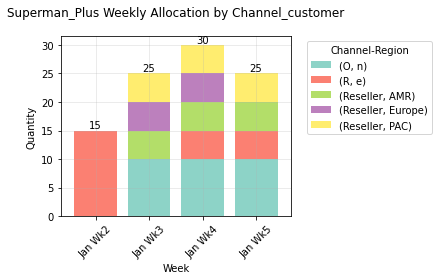

Channel     O     R Reseller            
Region      n     e      AMR Europe  PAC
Week                                    
Jan Wk2   0.0  15.0      0.0    0.0  0.0
Jan Wk3  10.0   0.0      5.0    5.0  5.0
Jan Wk4  10.0   5.0      5.0    5.0  5.0
Jan Wk5  10.0   5.0      5.0    0.0  5.0


In [18]:
# Create weekly allocation by channel visualization
plt.figure(figsize=(12, 6))

# Pivot data for stacked bar chart
Superman_Plus_Weekly_Allocation_Channel_customer = allo_df.pivot_table(
    index='Week',
    columns=['Channel', 'Region'],
    values='Allocated',
    aggfunc='sum',
    fill_value=0
)

# Plot stacked bars
colors = plt.cm.Set3(np.linspace(0, 1, len(Superman_Plus_Weekly_Allocation_Channel_customer.columns)))
Superman_Plus_Weekly_Allocation_Channel_customer.plot(
    kind='bar',
    stacked=True,
    color=colors,
    width=0.8
)

# Add total labels on top of bars
totals = Superman_Plus_Weekly_Allocation_Channel_customer.sum(axis=1)
for i, total in enumerate(totals):
    plt.text(i, total, f'{int(total)}', 
             ha='center', va='bottom')

# Customize plot
plt.title('Superman_Plus Weekly Allocation by Channel_customer', pad=20, fontsize=12)
plt.xlabel('Week')
plt.ylabel('Quantity')
plt.grid(True, alpha=0.3)
plt.legend(title='Channel-Region', 
          bbox_to_anchor=(1.05, 1), 
          loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()


plt.savefig('Allocation_output/Superman_Plus Weekly Allocation by Channel_customer.png', 
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')


plt.show()
plt.close()

# Display numerical summary
print(Superman_Plus_Weekly_Allocation_Channel_customer)

In [19]:
Superman_Plus_Weekly_Allocation_Channel_customer

Channel     O     R Reseller            
Region      n     e      AMR Europe  PAC
Week                                    
Jan Wk2   0.0  15.0      0.0    0.0  0.0
Jan Wk3  10.0   0.0      5.0    5.0  5.0
Jan Wk4  10.0   5.0      5.0    5.0  5.0
Jan Wk5  10.0   5.0      5.0    0.0  5.0

In [20]:
Superman_Plus_Weekly_Allocation_Channel_customer.to_excel('Allocation_output/Superman_Plus_Weekly_Allocation_Channel_customer.xlsx')

C:\Users\ye2208\AppData\Local\Temp/ipykernel_24640/2478607978.py:1: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.1' currently installed).
  Superman_Plus_Weekly_Allocation_Channel_customer.to_excel('Allocation_output/Superman_Plus_Weekly_Allocation_Channel_customer.xlsx')


2. Allocation Result Show

2.1 Total Supply , Demand , Fulfill 

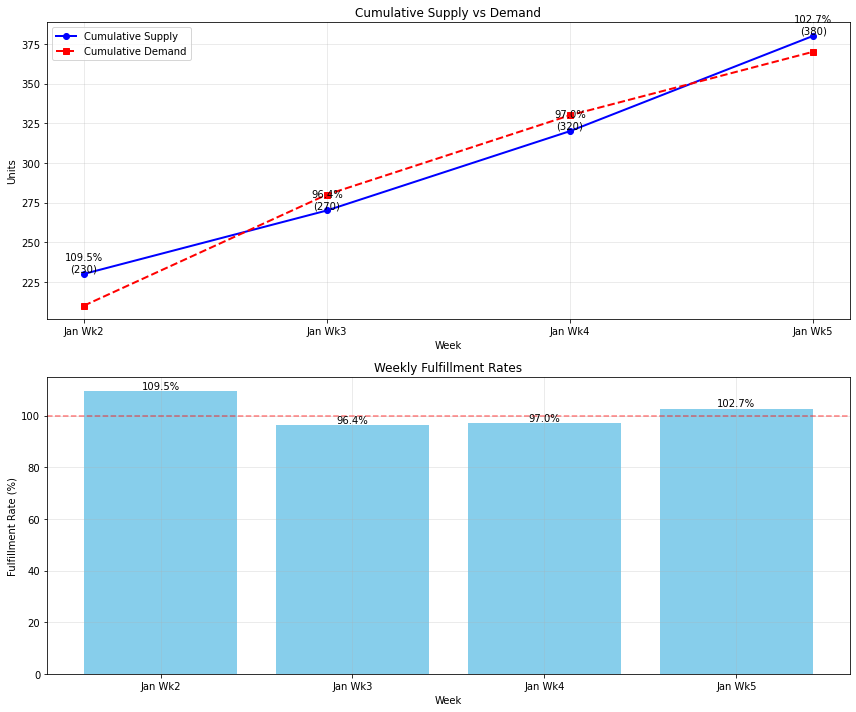


Weekly Supply and Demand Summary:
         Weekly Supply  Cum Supply  Cum Demand Superman  \
Jan Wk2             30         230                   85   
Jan Wk3             40         270                  100   
Jan Wk4             50         320                  110   
Jan Wk5             60         380                  120   

         Cum Demand Superman_Mini  Cum Demand Superman_Plus  Total Cum Demand  \
Jan Wk2                        40                        85               210   
Jan Wk3                        60                       120               280   
Jan Wk4                        70                       150               330   
Jan Wk5                        75                       175               370   

         Fulfillment Rate %  
Jan Wk2               109.5  
Jan Wk3                96.4  
Jan Wk4                97.0  
Jan Wk5               102.7  


In [21]:
# Calculate cumulative supply (including Week 1 built)
weeks = ['Jan Wk2', 'Jan Wk3', 'Jan Wk4', 'Jan Wk5']
supply_cum_actual = pd.Series(supply_cum.values(), index=weeks)

# Create summary DataFrame
summary_df = pd.DataFrame({
    'Weekly Supply': list(supply_weekly.values()),
    'Cum Supply': supply_cum_actual,
    'Cum Demand Superman': demand_cum['Superman'],
    'Cum Demand Superman_Mini': demand_cum['Superman_Mini'],
    'Cum Demand Superman_Plus': demand_cum['Superman_Plus']
}, index=weeks)

# Calculate total cumulative demand
summary_df['Total Cum Demand'] = (summary_df['Cum Demand Superman'] + 
                                 summary_df['Cum Demand Superman_Mini'] + 
                                 summary_df['Cum Demand Superman_Plus'])

# Calculate correct weekly fulfillment rates
summary_df['Fulfillment Rate %'] = (summary_df['Cum Supply'] / 
                                   summary_df['Total Cum Demand'] * 100).round(1)

# Create visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot 1: Cumulative Supply vs Demand
ax1.plot(weeks, summary_df['Cum Supply'].values, 'b-', marker='o', 
         label='Cumulative Supply', linewidth=2)
ax1.plot(weeks, summary_df['Total Cum Demand'].values, 'r--', marker='s', 
         label='Cumulative Demand', linewidth=2)

# Add fulfillment rate labels
for i, week in enumerate(weeks):
    rate = summary_df.loc[week, 'Fulfillment Rate %']
    supply = summary_df.loc[week, 'Cum Supply']
    ax1.text(i, supply, f'{rate}%\n({supply})', ha='center', va='bottom')

ax1.set_title('Cumulative Supply vs Demand')
ax1.set_xlabel('Week')
ax1.set_ylabel('Units')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Weekly Fulfillment Rates
ax2.bar(weeks, summary_df['Fulfillment Rate %'].values, color='skyblue')
ax2.axhline(y=100, color='r', linestyle='--', alpha=0.5)

# Add percentage labels on bars
for i, v in enumerate(summary_df['Fulfillment Rate %'].values):
    ax2.text(i, v, f'{v}%', ha='center', va='bottom')

ax2.set_title('Weekly Fulfillment Rates')
ax2.set_xlabel('Week')
ax2.set_ylabel('Fulfillment Rate (%)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()

plt.savefig('Allocation_output/Cumulative Supply vs Demand.png', 
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')

plt.show()
plt.close()

# Display detailed summary
print("\nWeekly Supply and Demand Summary:")
print(summary_df)

In [22]:
summary_df

,Weekly Supply,Cum Supply,Cum Demand Superman,Cum Demand Superman_Mini,Cum Demand Superman_Plus,Total Cum Demand,Fulfillment Rate %
Jan Wk2,30,230,85,40,85,210,109.5
Jan Wk3,40,270,100,60,120,280,96.4
Jan Wk4,50,320,110,70,150,330,97.0
Jan Wk5,60,380,120,75,175,370,102.7


2. By product  Supply , Demand , Fulfill 

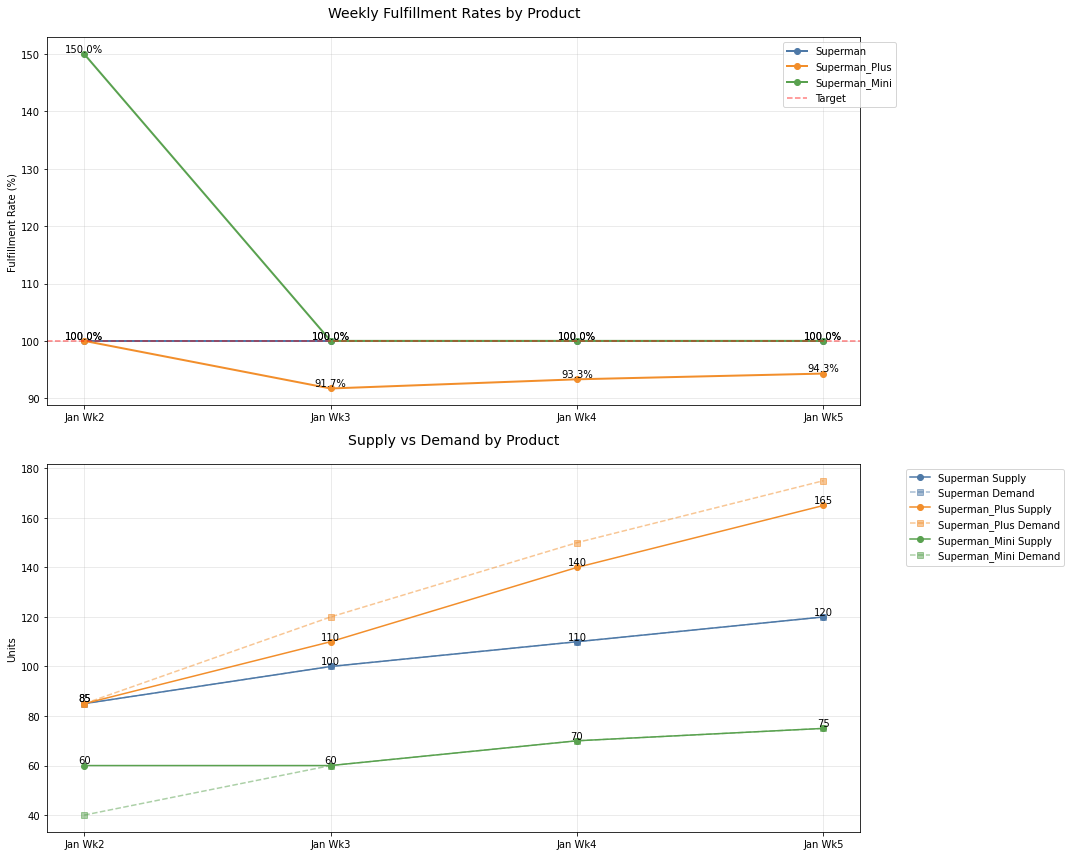


Weekly Fulfillment Rates by Product (%):
         Superman  Superman_Plus  Superman_Mini
Jan Wk2     100.0          100.0          150.0
Jan Wk3     100.0           91.7          100.0
Jan Wk4     100.0           93.3          100.0
Jan Wk5     100.0           94.3          100.0


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define weeks and products
weeks = ['Jan Wk2', 'Jan Wk3', 'Jan Wk4', 'Jan Wk5']
products = ['Superman', 'Superman_Plus', 'Superman_Mini']

# Calculate cumulative built + allocated by product
cum_alloc = {
    'Superman': np.array([85, 100, 110, 120]),      # Wk2-Wk5
    'Superman_Plus': np.array([85, 110, 140, 165]), 
    'Superman_Mini': np.array([60, 60, 70, 75])     
}

# Define cumulative demand (make sure it matches weeks)
demand_data = {
    'Superman': np.array([85, 100, 110, 120]),      # Wk2-Wk5
    'Superman_Plus': np.array([85, 120, 150, 175]), 
    'Superman_Mini': np.array([40, 60, 70, 75])     
}

# Create detailed summary DataFrame
detailed_df = pd.DataFrame(index=weeks)

for product in products:
    detailed_df[f'{product} Supply'] = cum_alloc[product]
    detailed_df[f'{product} Demand'] = demand_data[product]
    detailed_df[f'{product} Fulfill %'] = np.round(
        (detailed_df[f'{product} Supply'].values / 
         detailed_df[f'{product} Demand'].values * 100), 1)

# Create visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Define colors - Updated to match exact product names
colors = {
    'Superman': '#4E79A7',        # Blue
    'Superman_Plus': '#F28E2B',   # Orange
    'Superman_Mini': '#59A14F'    # Green
}

# Plot 1: Fulfillment Rates by Product
for product in products:
    rates = detailed_df[f'{product} Fulfill %'].values
    ax1.plot(weeks, rates, marker='o', linewidth=2, 
             label=product, color=colors[product])
    
    # Add percentage labels
    for i, rate in enumerate(rates):
        ax1.text(i, rate, f'{rate}%', ha='center', va='bottom')

ax1.axhline(y=100, color='r', linestyle='--', alpha=0.5, label='Target')
ax1.set_title('Weekly Fulfillment Rates by Product', pad=20, fontsize=14)
ax1.set_ylabel('Fulfillment Rate (%)')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1))

# Plot 2: Supply vs Demand by Product
for product in products:
    supply = detailed_df[f'{product} Supply'].values
    demand = detailed_df[f'{product} Demand'].values
    
    ax2.plot(weeks, supply, '-', marker='o', 
             label=f'{product} Supply', color=colors[product])
    ax2.plot(weeks, demand, '--', marker='s', 
             label=f'{product} Demand', color=colors[product], alpha=0.5)
    
    # Add supply numbers
    for i, sup in enumerate(supply):
        ax2.text(i, sup, f'{int(sup)}', ha='center', va='bottom')

ax2.set_title('Supply vs Demand by Product', pad=20, fontsize=14)
ax2.set_ylabel('Units')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.savefig('Allocation_output/Supply vs Demand by Product.png', 
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')


plt.show()
plt.close()


# Display summary table with proper column names
Fulfill_df_product = pd.DataFrame({
    product: detailed_df[f'{product} Fulfill %'].values 
    for product in products
}, index=weeks)

print("\nWeekly Fulfillment Rates by Product (%):")
print(Fulfill_df_product.round(1))

In [24]:
Fulfill_df_product

,Superman,Superman_Plus,Superman_Mini
Jan Wk2,100.0,100.0,150.0
Jan Wk3,100.0,91.7,100.0
Jan Wk4,100.0,93.3,100.0
Jan Wk5,100.0,94.3,100.0


In [25]:
detailed_df

,Superman Supply,Superman Demand,Superman Fulfill %,Superman_Plus Supply,Superman_Plus Demand,Superman_Plus Fulfill %,Superman_Mini Supply,Superman_Mini Demand,Superman_Mini Fulfill %
Jan Wk2,85,85,100.0,85,85,100.0,60,40,150.0
Jan Wk3,100,100,100.0,110,120,91.7,60,60,100.0
Jan Wk4,110,110,100.0,140,150,93.3,70,70,100.0
Jan Wk5,120,120,100.0,165,175,94.3,75,75,100.0
